In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext autoreload
%autoreload 2

from utils.DataPrepUtils import xy_backtest
from ModelTesters.ModelTester import ModelTester
from utils.progress import ProgressBar
progress = ProgressBar()

In [2]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri, numpy2ri
from rpy2.robjects.vectors import FloatVector

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from utils.progress import ProgressBar
progress = ProgressBar()

In [6]:
# Setup to parse to R
pandas2ri.activate()
ts = ro.r('ts')
forecast = importr('forecast')

In [106]:
data = data[['window_1_0', 'window_1_1', 'window_1_2', 'window_1_3']]
data = data.drop(axis=0, index=np.arange(600, len(data)))

In [7]:
data.shape

(86258, 60)

## Auto Arima model from R

In [335]:
class AutoArima():
    
    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.arima_models = []
    
    
    def fit(self, data, labels):
        self.data = data
    
    def predict(self, data, bar=None, use_every=1):
        print(self.data.shape, data.shape)
        all_data = np.hstack([self.data, data])
        results = np.zeros((len(data), self.horizon))
        
        for i in range(0, len(data), use_every):
            arima_model = forecast.auto_arima(all_data[len(self.data) + i - self.back_horizon: len(self.data) + i])
            arima_forecast = forecast.forecast(arima_model, h=self.horizon)
            arima_output = dict(zip(arima_forecast.names, map(list,list(arima_forecast))))
            self.arima_models.append(dict(zip(arima_forecast.names, map(list,list(arima_forecast)))))
            
            results[i] = np.array(arima_output['mean'])
            
            if bar is not None:
                bar.progress()

        return results

In [336]:
from utils.ErrorMetrics import calculate_all_errors
import datetime as dt

def speed_up_calc(tester, data, horizon, use_every=1):
    # Loading bar
    split = int(0.20 * len(data))
    tester.progressBar.set_length(len(data.columns) * (len(data) - split) // use_every)
    start = dt.datetime.now()
    
    # walk speed up
    for i, column in enumerate(data.keys()):

        # Split into train and test data
        train, test = data[column][:split].values, data[column][split:].values
        
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]

        tester.model.fit(train, train)
#         pred = tester.model.predict(test, bar=tester.progressBar, use_every=use_every)
        pred = tester.model.predict(test, bar=tester.progressBar, use_every=use_every)
        
        tester.predictions[column] = pred

        errors = {}
        for key, value in calculate_all_errors(train, test, pred, horizon).items():
            errors[key] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[column]], inplace=True)
        tester.errors = tester.errors.append(t)
        
        end = dt.datetime.now()
        print("Iteration in:", (dt.datetime.now() - start).microseconds / 10**6, "s")
        
        print("estimated total time:", ((len(data.columns) * (len(data) - split) // use_every) - i) * (end - start))

In [337]:
arima = AutoArima(horizon, 120)
t = ModelTester(data, arima, horizon, 0.2)
speed_up_calc(t, data[['window_1_0']][:800], horizon, use_every=60)

Progress: [####################] 100.0%
(540, 60) (540, 60)
Iteration in: 0.228199 s
estimated total time: 0:00:12.281990


In [340]:
for model in t.model.arima_models:
    print(model['method'])

['ARIMA(0,2,1)']
['ARIMA(2,2,2)']
['ARIMA(1,2,3)']
['ARIMA(1,2,1)']
['ARIMA(1,2,2)']
['ARIMA(2,2,1)']
['ARIMA(0,2,2)']
['ARIMA(0,1,0) with drift']
['ARIMA(0,1,0) with drift']
['ARIMA(0,1,0)']


## Forecasts

In [321]:
# Note: horizon doesnt impact prediction, so can just do 60 minutes and take the first 1 or 5 samples

In [11]:
horizon = 60
arima = AutoArima(horizon, 120)
tester = ModelTester(data, arima, horizon, 0.2)

In [32]:
speed_up_calc(tester, data, horizon, use_every=60)

Progress: [####################] 100.0%
(68940, 60) (68940, 60)
Iteration in: 0.921617 s
estimated total time: 10736 days, 8:29:47.648916


In [69]:
# Remove all zero predictions
np.argwhere(tester.predictions['window_1_0'].all() == 0)

array([[0]], dtype=int64)

In [96]:
for key in tester.predictions.keys():
    tester.predictions[key] = tester.predictions[key][np.where(tester.predictions[key].any(axis=1))[0]]

In [36]:
import pickle

pickle.dump(tester.predictions, open('results/arima_preds.pck', 'wb+'))

## Temp

In [180]:
data[key].values[[[0,1,2,3,4]]]

array([35.753, 35.679, 35.606, 35.532, 35.458])

In [227]:
use_every = 60
key = 'window_1_0'
split = int(0.20 * len(data) * 1)
horizon = 1

preds = tester.predictions[key][:, :horizon]
train, test = data[key][:split], data[key][split:]

indexer = np.arange(horizon)[None, :] + use_every * np.arange((len(test)) // (horizon + use_every))[:, None]
test = test.values[indexer]

indexer = np.arange(horizon)[None, :] + use_every * np.arange((len(train)) // (horizon + use_every))[:, None]
train = train.values[indexer]

preds, test = preds[:min(len(preds), len(test))], test[:min(len(preds), len(test))]

In [229]:
preds.shape, test.shape, train.shape

((1131, 1), (1131, 1), (282, 1))

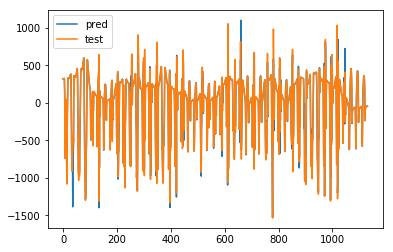

In [230]:
plt.plot(preds[:, :5].flatten())
plt.plot(test[:, :5].flatten())
plt.legend(['pred', 'test'])
# plt.xlim([1000, 1200])

In [226]:
# RMSE
(np.mean((preds - test)**2))**0.5

87.05376080814173

In [273]:
def lower_horizon(trained_tester, new_tester, data, horizon, use_every=1):
    split = int(0.20 * len(data) * 1)
    new_tester.predictions = {}
    
    for key, col in trained_tester.predictions.items():
        pred = col[:, :horizon]
        train, test = data[key][:split], data[key][split:]

        indexer = np.arange(horizon)[None, :] + use_every * np.arange((len(test)) // (horizon + use_every))[:, None]
        test = test.values[indexer]

        indexer = np.arange(horizon)[None, :] + use_every * np.arange((len(train)) // (horizon + use_every))[:, None]
        train = train.values[indexer]

        pred, test = pred[:min(len(pred), len(test))], test[:min(len(pred), len(test))]
        new_tester.predictions[key] = pred

        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]
        pred, test = pred[:min(len(pred), len(test))], test[:min(len(pred), len(test))]

        # Compute errors
        print(train.shape, test.shape, pred.shape)
        errors = {}
        for err, value in calculate_all_errors(train, test.flatten(), pred, horizon, expand_actual=False).items():
            errors[err] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[key]], inplace=True)
        new_tester.errors = new_tester.errors.append(t)

## 1 minute horizon

In [283]:
horizon = 1

from ModelTesters.ModelTester import ModelTester
one_min_tester = ModelTester(data, arima, horizon, 0.2)

In [284]:
lower_horizon(tester, one_min_tester, data, horizon, 60)

(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (1131, 1) (1131, 1)
(1131,) (1131, 1)
(282, 1) (113

In [285]:
one_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,25.045907,87.053761,20.475501,9.892797,0.108425,-10.64724,0.082409
window_1_1,26.734307,109.189741,13.855417,7.805132,0.139777,2.78557,0.089319
window_1_2,37.463845,113.893880,24.799408,13.435911,0.119967,-2.89306,0.116291
window_1_3,43.086570,126.822227,16.685415,12.884629,0.111319,12.87052,0.108882
window_1_4,44.156384,118.823947,35.892003,15.788552,0.154798,-13.67964,0.156617


(-300, 500)

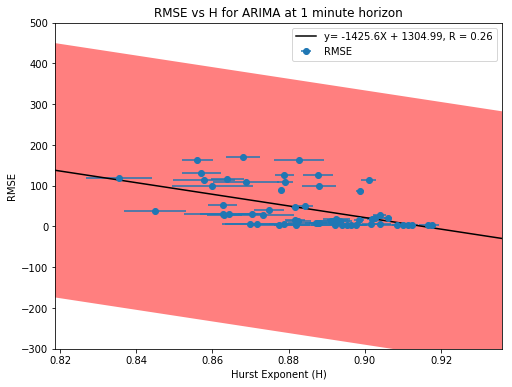

In [312]:
one_min_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for ARIMA at 1 minute horizon')
plt.ylim([-300, 500])

## 5 minute horizon

In [287]:
horizon = 5

from ModelTesters.ModelTester import ModelTester
five_min_tester = ModelTester(data, arima, horizon, 0.2)

In [288]:
lower_horizon(tester, five_min_tester, data, horizon=5, use_every=60)

(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (1060, 5) (1060, 5)
(5300,) (1060, 5)
(265, 5) (106

In [289]:
five_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,50.232523,162.423256,43.667907,16.317440,0.229189,5.18895,0.163215
window_1_1,56.951788,221.774024,25.222718,14.099685,0.296372,5.40112,0.188905
window_1_2,78.533401,223.797482,514.367312,23.593816,0.257212,5.04482,0.247513
window_1_3,87.249273,229.302630,60.680844,23.781893,0.224237,-11.24272,0.225422
window_1_4,97.780101,244.037454,120.552581,28.067438,0.326089,-17.49322,0.340960


(-400, 800)

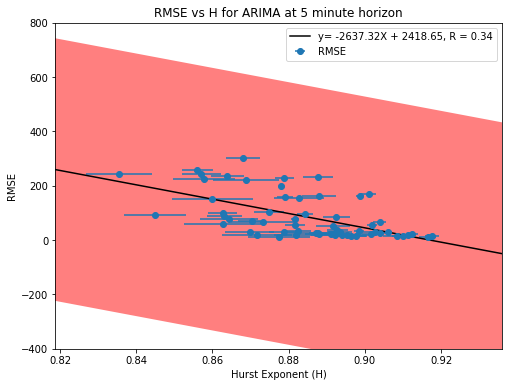

In [314]:
five_min_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for ARIMA at 5 minute horizon')
plt.ylim([-400, 800])

## 60 minute horizon

In [291]:
horizon = 60

from ModelTesters.ModelTester import ModelTester
sixty_min_tester = ModelTester(data, arima, horizon, 0.2)

In [292]:
lower_horizon(tester, sixty_min_tester, data, horizon=60, use_every=60)

(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) (540, 60)
(32400,) (540, 60)
(143, 60) (540, 60) 

In [293]:
sixty_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,129.918294,304.513831,188.296673,41.102029,0.746181,100.97536,0.421587
window_1_1,176.537725,1262.907083,126.179493,35.644177,0.942981,245.89573,0.597941
window_1_2,170.738543,356.082176,220.592354,48.995822,0.567437,-23.63032,0.555847
window_1_3,220.868597,448.570096,156.900789,50.146145,0.561815,-15.09645,0.559801
window_1_4,243.485227,478.197414,333.422804,64.285452,0.799616,-21.81565,0.835493


(-800, 2000)

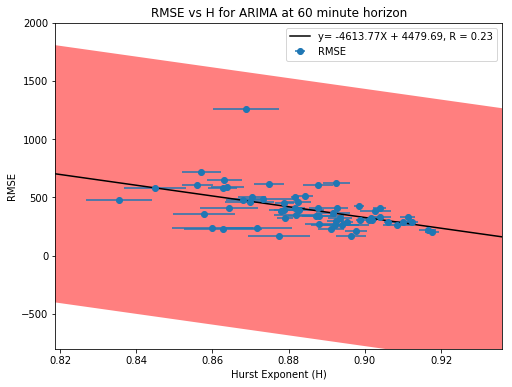

In [316]:
sixty_min_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for ARIMA at 60 minute horizon')
plt.ylim([-800, 2000])

In [ ]:
--------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------

In [95]:
plt.plot(np.arange(120, 600), one_min_tester.predictions['window_1_1'])
plt.plot(data['window_1_1'][:500])

In [99]:
hurst_estimates['avg'].shape, one_min_tester.errors['MASE'].shape, hurst_estimates['std'].shape

((60,), (2,), (60,))

In [102]:
hurst_estimates.head()

,Agr Var.,Higuchi,Abs val.,avg,std
Unnamed: 0,,,,,
window_1_0,0.899837,0.897147,0.899166,0.898717,0.001143
window_1_1,0.857475,0.878807,0.870051,0.868778,0.008755
window_1_2,0.846924,0.866159,0.860166,0.857749,0.008036
window_1_3,0.875449,0.879919,0.881300,0.878890,0.002497
window_1_4,0.823455,0.839136,0.843857,0.835483,0.008721


In [318]:
five_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,50.232523,162.423256,43.667907,16.317440,0.229189,5.18895,0.163215
window_1_1,56.951788,221.774024,25.222718,14.099685,0.296372,5.40112,0.188905
window_1_2,78.533401,223.797482,514.367312,23.593816,0.257212,5.04482,0.247513
window_1_3,87.249273,229.302630,60.680844,23.781893,0.224237,-11.24272,0.225422
window_1_4,97.780101,244.037454,120.552581,28.067438,0.326089,-17.49322,0.340960


(5305,)


ValueError: x and y must have same first dimension, but have shapes (1061,) and (5305,)

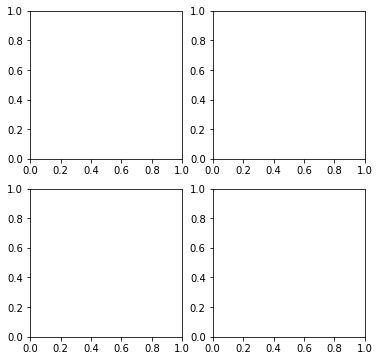

In [317]:
five_min_tester.visualise_result([0, 1])

In [12]:


arima.fit(data['window_1_0'][:10000], data['window_1_0'][:10000])
pred = arima.predict(data['window_1_0'][10000:])

(10000,) (0,)


In [35]:
pred

array([], shape=(0, 5), dtype=float64)

In [29]:
arima_model = forecast.auto_arima(data['window_1_0'][:1000])

In [21]:
arima_forecast = forecast.forecast(arima_model, h=60)

In [22]:
arima_output = dict(zip(arima_forecast.names, map(list,list(arima_forecast))))

(900, 1060)

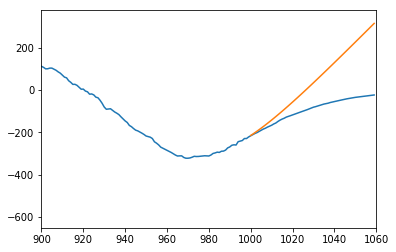

In [24]:
%matplotlib inline
plt.plot(data['window_1_0'][:1060])
plt.plot(np.arange(60) + 1000, arima_output['mean'])
plt.xlim([900, 1060])